100.0%
100.0%
100.0%
100.0%



Training with SGD
Epoch [1/10], SGD, Loss: 2.2405, Accuracy: 42.09%
Epoch [2/10], SGD, Loss: 2.0215, Accuracy: 56.23%
Epoch [3/10], SGD, Loss: 1.6506, Accuracy: 69.83%
Epoch [4/10], SGD, Loss: 1.2101, Accuracy: 79.44%
Epoch [5/10], SGD, Loss: 0.8869, Accuracy: 83.46%
Epoch [6/10], SGD, Loss: 0.7026, Accuracy: 85.53%
Epoch [7/10], SGD, Loss: 0.5960, Accuracy: 86.90%
Epoch [8/10], SGD, Loss: 0.5290, Accuracy: 87.80%
Epoch [9/10], SGD, Loss: 0.4836, Accuracy: 88.30%
Epoch [10/10], SGD, Loss: 0.4510, Accuracy: 88.77%

Training with SGD_Momentum
Epoch [1/10], SGD_Momentum, Loss: 1.1027, Accuracy: 88.14%
Epoch [2/10], SGD_Momentum, Loss: 0.3798, Accuracy: 90.77%
Epoch [3/10], SGD_Momentum, Loss: 0.3069, Accuracy: 92.02%
Epoch [4/10], SGD_Momentum, Loss: 0.2679, Accuracy: 92.87%
Epoch [5/10], SGD_Momentum, Loss: 0.2392, Accuracy: 93.67%
Epoch [6/10], SGD_Momentum, Loss: 0.2158, Accuracy: 94.10%
Epoch [7/10], SGD_Momentum, Loss: 0.1964, Accuracy: 94.51%
Epoch [8/10], SGD_Momentum, Loss: 0.180

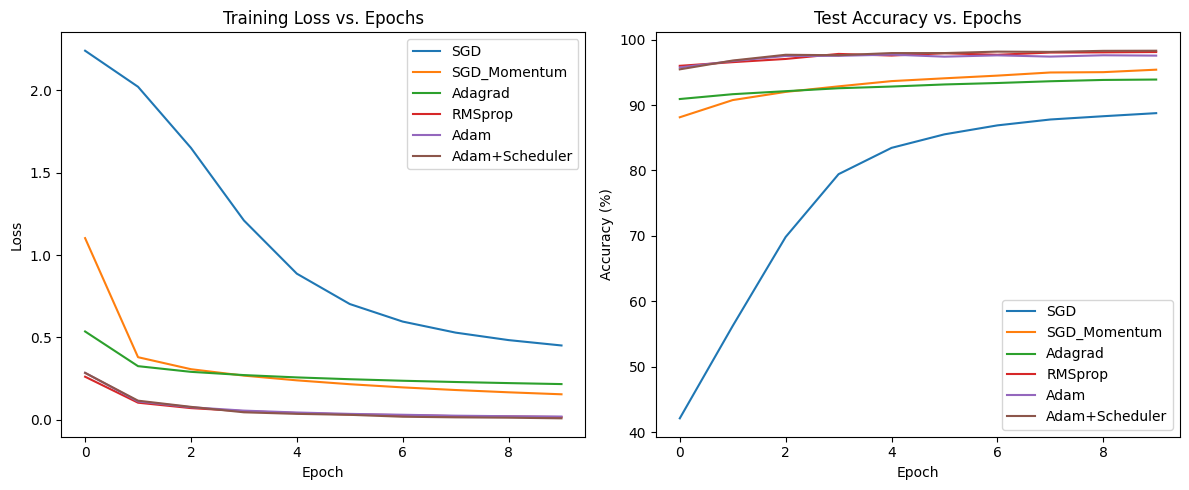


Final Test Accuracies:
SGD: 88.77%
SGD_Momentum: 95.42%
Adagrad: 93.91%
RMSprop: 98.12%
Adam: 97.57%
Adam+Scheduler: 98.32%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

#set seed for reproducibility
torch.manual_seed(42)

#device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#hyperparameters
input_size = 784  # 28x28
hidden1_size = 200
hidden2_size = 50
output_size = 10
num_epochs = 10
batch_size = 100
learning_rate = 0.001

#MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

#define MLP model (784-200-50-10)
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, output_size)
        
    def forward(self, x):
        x = x.reshape(-1, input_size)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

#function to train and evaluate the model
def train_and_evaluate(optimizer_name, use_scheduler=False):
    model = MLP().to(device)
    criterion = nn.CrossEntropyLoss()
    
    #select optimizer
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD_Momentum':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_name == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    #scheduler
    scheduler = None
    if use_scheduler:
        scheduler = StepLR(optimizer, step_size=3, gamma=0.5)
    
    train_losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        #training
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            #forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            #backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        #update scheduler
        if scheduler:
            scheduler.step()
        
        #testing
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            accuracy = 100 * correct / total
            test_accuracies.append(accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], {optimizer_name}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    return train_losses, test_accuracies, accuracy

#test different optimizers
optimizers = ['SGD', 'SGD_Momentum', 'Adagrad', 'RMSprop', 'Adam']
results = {}

for opt in optimizers:
    print(f"\nTraining with {opt}")
    train_losses, test_accuracies, final_acc = train_and_evaluate(opt)
    results[opt] = {
        'train_losses': train_losses,
        'test_accuracies': test_accuracies,
        'final_accuracy': final_acc
    }

#adam with scheduler
print("\nTraining with Adam + Scheduler")
train_losses, test_accuracies, final_acc = train_and_evaluate('Adam', use_scheduler=True)
results['Adam+Scheduler'] = {
    'train_losses': train_losses,
    'test_accuracies': test_accuracies,
    'final_accuracy': final_acc
}

#plot results
plt.figure(figsize=(12, 5))

#plot the training loss
plt.subplot(1, 2, 1)
for opt, res in results.items():
    plt.plot(res['train_losses'], label=opt)
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#plot test accuracy
plt.subplot(1, 2, 2)
for opt, res in results.items():
    plt.plot(res['test_accuracies'], label=opt)
plt.title('Test Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('optimizer_comparison.png')
plt.show()

#print final results
print("\nFinal Test Accuracies:")
for opt, res in results.items():
    print(f"{opt}: {res['final_accuracy']:.2f}%")

Epoch [100/4000], MLP Loss: 0.1005, Fourier Loss: 0.1595
Epoch [200/4000], MLP Loss: 0.0425, Fourier Loss: 0.0520
Epoch [300/4000], MLP Loss: 0.0392, Fourier Loss: 0.0407
Epoch [400/4000], MLP Loss: 0.0387, Fourier Loss: 0.0395
Epoch [500/4000], MLP Loss: 0.0389, Fourier Loss: 0.0390
Epoch [600/4000], MLP Loss: 0.0394, Fourier Loss: 0.0384
Epoch [700/4000], MLP Loss: 0.0378, Fourier Loss: 0.0373
Epoch [800/4000], MLP Loss: 0.0376, Fourier Loss: 0.0355
Epoch [900/4000], MLP Loss: 0.0370, Fourier Loss: 0.0331
Epoch [1000/4000], MLP Loss: 0.0365, Fourier Loss: 0.0296
Epoch [1100/4000], MLP Loss: 0.0361, Fourier Loss: 0.0266
Epoch [1200/4000], MLP Loss: 0.0355, Fourier Loss: 0.0236
Epoch [1300/4000], MLP Loss: 0.0299, Fourier Loss: 0.0207
Epoch [1400/4000], MLP Loss: 0.0279, Fourier Loss: 0.0181
Epoch [1500/4000], MLP Loss: 0.0266, Fourier Loss: 0.0152
Epoch [1600/4000], MLP Loss: 0.0253, Fourier Loss: 0.0129
Epoch [1700/4000], MLP Loss: 0.0245, Fourier Loss: 0.0132
Epoch [1800/4000], MLP 

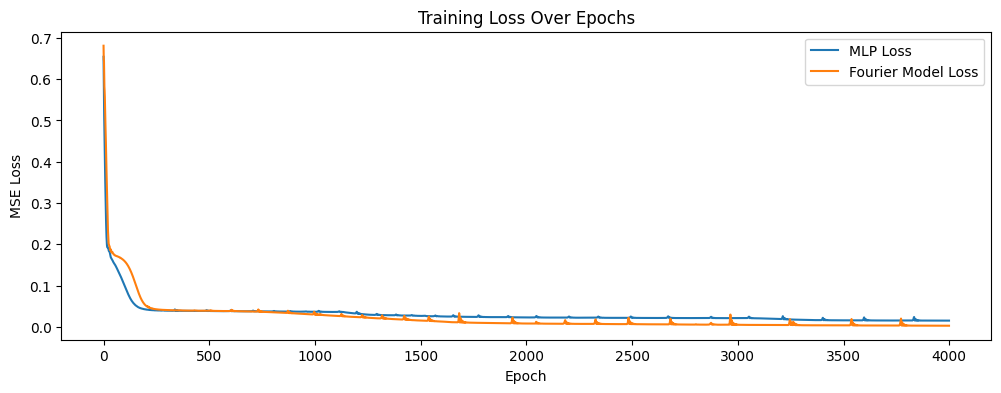

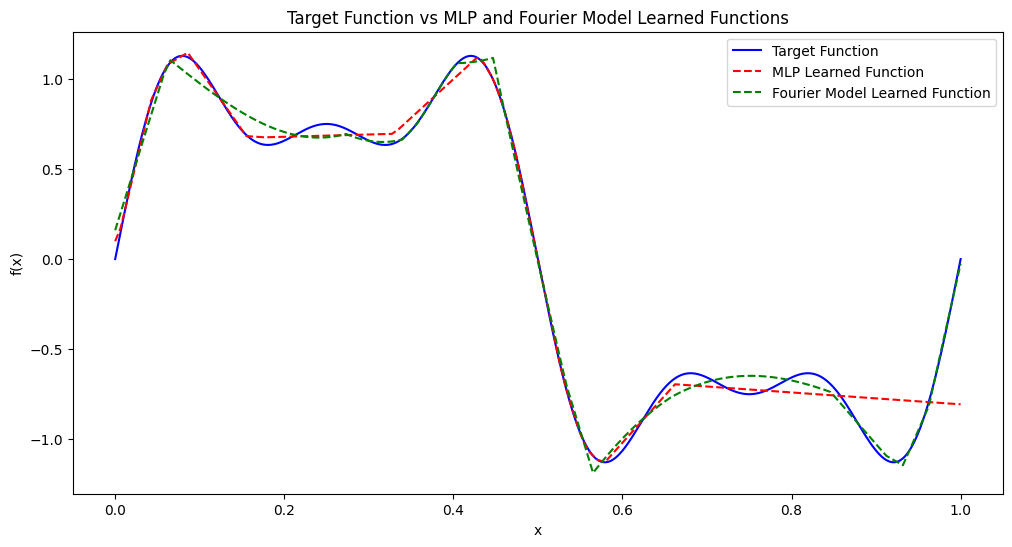

In [ ]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Define the target function as the sum of 3 sinusoids
def target_function(x):
    return np.sin(2 * np.pi * 1.0 * x) + 0.5 * np.sin(2 * np.pi * 3.0 * x) + 0.25 * np.sin(2 * np.pi * 5.0 * x)

# Generate dataset with 4000 points
x = np.linspace(0, 1, 4000)  # 4000 points between 0 and 1
y = target_function(x)

# Convert to PyTorch tensors
x_train = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y_train = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Define the original 3-layer MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(1, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.fc3(x)

# Define the LFF (Learnable Fourier Feature) layer
class LFF(nn.Module):
    def __init__(self, in_features, out_features, scale=1.0, init="iso", sincos=False):
        super().__init__()
        self.in_features = in_features
        self.sincos = sincos
        self.out_features = out_features
        self.scale = scale
        if self.sincos:
            self.linear = nn.Linear(in_features, out_features // 2)
        else:
            self.linear = nn.Linear(in_features, out_features)
        if init == "iso":
            nn.init.normal_(self.linear.weight, 0, scale / in_features)
            nn.init.normal_(self.linear.bias, 0, 1)
        else:
            nn.init.uniform_(self.linear.weight, -scale / in_features, scale / in_features)
            nn.init.uniform_(self.linear.bias, -1, 1)
        if self.sincos:
            nn.init.zeros_(self.linear.bias)

    def forward(self, x):
        x = np.pi * self.linear(x)
        if self.sincos:
            return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)
        else:
            return torch.sin(x)

# Define the FourierModel with the LFF layer
class FourierModel(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(FourierModel, self).__init__()
        self.input_layer = LFF(state_dim, hidden_dim, scale=0.1, init="iso", sincos=False)
        self.mid_layer = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.mid_layer(x)
        x = self.relu2(x)
        return self.output(x)

# Initialize models, loss function, and optimizers
mlp_model = MLP()
fourier_model = FourierModel(state_dim=1, action_dim=1, hidden_dim=100)

criterion = nn.MSELoss()
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.002)
fourier_optimizer = optim.Adam(fourier_model.parameters(), lr=0.002)

# Training loop for both models
num_epochs = 4000
mlp_losses = []
fourier_losses = []

for epoch in range(num_epochs):
    # Train MLP model
    mlp_model.train()
    mlp_optimizer.zero_grad()
    mlp_y_pred = mlp_model(x_train)
    mlp_loss = criterion(mlp_y_pred, y_train)
    mlp_loss.backward()
    mlp_optimizer.step()
    mlp_losses.append(mlp_loss.item())

    # Train Fourier model
    fourier_model.train()
    fourier_optimizer.zero_grad()
    fourier_y_pred = fourier_model(x_train)
    fourier_loss = criterion(fourier_y_pred, y_train)
    fourier_loss.backward()
    fourier_optimizer.step()
    fourier_losses.append(fourier_loss.item())

    # Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], MLP Loss: {mlp_loss.item():.4f}, Fourier Loss: {fourier_loss.item():.4f}")

# Plot the training loss for both models
plt.figure(figsize=(12, 4))
plt.plot(mlp_losses, label="MLP Loss")
plt.plot(fourier_losses, label="Fourier Model Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# Plot the target function vs. the learned functions
with torch.no_grad():
    mlp_y_learned = mlp_model(x_train).numpy()
    fourier_y_learned = fourier_model(x_train).numpy()

plt.figure(figsize=(12, 6))
plt.plot(x, y, label="Target Function", color='blue')
plt.plot(x, mlp_y_learned, label="MLP Learned Function", color='red', linestyle='--')
plt.plot(x, fourier_y_learned, label="Fourier Model Learned Function", color='green', linestyle='--')
plt.title("Target Function vs MLP and Fourier Model Learned Functions")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
